# Diabetes Prediction using ANN with Pytorch Library

### Importing Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

### Loading the data

In [ ]:
df=pd.read_csv('diabetes.csv')

In [ ]:
df.head()

### Data Preprocessing and Visualisation

In [ ]:
sns.boxplot(df['BloodPressure'])

In [ ]:
sns.boxplot(df['Glucose'])

In [ ]:
inds=df.loc[df['Glucose']<25].index
inds

In [ ]:
df.drop(index=inds,inplace=True)

In [ ]:
sns.boxplot(df['Glucose'])

In [ ]:
df.loc[df['BloodPressure']<10]

In [ ]:
df.shape

In [ ]:
sns.boxplot(df['SkinThickness'])

In [ ]:
df.loc[df['SkinThickness']>60].index

In [ ]:
df.drop(index=[445,579],inplace=True)

In [ ]:
sns.boxplot(df['SkinThickness'])

In [ ]:
sns.boxplot(df['Insulin'])

In [ ]:
sns.boxplot(data=df,y='Insulin',x='Outcome')

In [ ]:
inds=df.loc[df['Insulin']>500].index

In [ ]:
df.drop(index=inds,inplace=True)

In [ ]:
sns.boxplot(data=df,y='Insulin',x='Outcome')

In [ ]:
sns.boxplot(df['Insulin'])

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
sns.boxplot(df['BMI'])

In [ ]:
df.loc[df['BMI']<10]

In [ ]:
df.loc[(df['Outcome']==0),'BMI'].mean()

In [ ]:
df.loc[df['BMI']<10,'BMI']=30.24

In [ ]:
df.loc[df['BMI']<10]

In [ ]:
sns.boxplot(df['BMI'])

In [ ]:
df.loc[(df['Insulin']==0)&(df['Outcome']==0)].count()

In [ ]:
sns.boxplot(y=df['Insulin'],x=df['Outcome'])

In [ ]:
sns.boxplot(df['Insulin'])

In [ ]:
sns.boxplot(df['Age'])

In [ ]:
df.loc[df['Age']>70]

In [ ]:
sns.boxplot(df['DiabetesPedigreeFunction'])

In [ ]:
inds=df.loc[df['DiabetesPedigreeFunction']>1.5].index

In [ ]:
sns.boxplot(data=df,x='Outcome',y='DiabetesPedigreeFunction')

In [ ]:
df.drop(index=inds,inplace=True)

In [ ]:
sns.boxplot(data=df,x='Outcome',y='DiabetesPedigreeFunction')

In [ ]:
sns.boxplot(df['DiabetesPedigreeFunction'])

#### Note: One thing that should be noted is there are some good outliers that are helpful and should not be removed.

### Splitting the data and converting into tensors

In [ ]:
df.to_csv('diabetes_v1.csv',index=False)

In [3]:
df=pd.read_csv('diabetes_v1.csv')

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
739,10,101,76,48,180,32.9,0.171,63,0
740,2,122,70,27,0,36.8,0.340,27,0
741,5,121,72,23,112,26.2,0.245,30,0
742,1,126,60,0,0,30.1,0.349,47,1


In [5]:
y=df['Outcome']
X=df.drop(columns='Outcome')

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,stratify=y)

In [7]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [8]:

X_train,X_test=map(torch.FloatTensor,(X_train,X_test))

y_train,y_test=map(torch.LongTensor,(y_train,y_test))

In [9]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([558, 8]),
 torch.Size([186, 8]),
 torch.Size([558]),
 torch.Size([186]))

## Creating the ANN

### Initialisation of the Neural Network and also the forward Propogation

In [10]:
class ANN(nn.Module):
    def __init__(self,input_features=8,hidden1=4,hidden2=2,out_features=2):
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1,hidden2)
        self.out=nn.Linear(hidden2,out_features)
        
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        #x=F.softmax(self.out(x))
        x=self.out(x)
        return x

In [11]:
torch.manual_seed(20)

In [12]:
model=ANN()

In [13]:
model.parameters

<bound method Module.parameters of ANN(
  (f_connected1): Linear(in_features=8, out_features=4, bias=True)
  (f_connected2): Linear(in_features=4, out_features=2, bias=True)
  (out): Linear(in_features=2, out_features=2, bias=True)
)>

### Back propagation

In [14]:
loss_function=nn.CrossEntropyLoss()

In [15]:
optimizer=optim.Adamax(model.parameters(),lr=0.02)

In [16]:
epochs=10000
final_losses=[]
for i in range(epochs):
    i+=1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i%1000==1:
        print('Epoch Number:{} and the loss is {}'.format(i,loss.item()))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

Epoch Number:1 and the loss is 1.052199125289917
Epoch Number:1001 and the loss is 0.44167885184288025
Epoch Number:2001 and the loss is 0.4437094032764435
Epoch Number:3001 and the loss is 0.4476455748081207
Epoch Number:4001 and the loss is 0.43758732080459595
Epoch Number:5001 and the loss is 0.43785762786865234
Epoch Number:6001 and the loss is 0.4363487958908081
Epoch Number:7001 and the loss is 0.4372395873069763
Epoch Number:8001 and the loss is 0.434928297996521
Epoch Number:9001 and the loss is 0.4342306852340698


### Plot the loss

Text(0, 0.5, 'Loss')

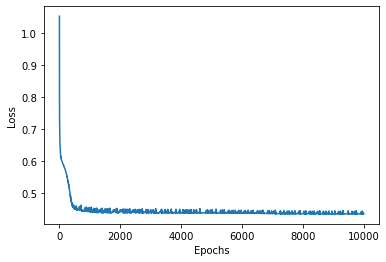

In [17]:
plt.plot(range(epochs),final_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Tried other optimisation functions like Adagrad, SGD,RMSProp, Adam but Adamax has given better accuracy.Tried with different number of epochs and choose the best. Used multiple number of hidden layers with different nuerons but when I constrcuted a heavy neural network, it lead to over fitting. So with minimal number of hidden layers, achieved good accuracy.


### Predictions on test data

In [18]:
preds=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=(model(data))
       # print(y_pred.argmax())
        preds.append(y_pred.argmax().item())

In [19]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score

In [20]:
confusion_matrix(preds,y_test)

array([[108,  27],
       [ 14,  37]], dtype=int64)

In [21]:
f1_score(y_test,preds)

0.6434782608695652

In [22]:
accuracy_score(y_test,preds)


0.7795698924731183

## Saving the Model

In [ ]:
torch.save(model,'diabetes.pt')

In [ ]:
model=torch.load('diabetes.pt')

In [ ]:
model.eval()

In [ ]:
torch.save(model,'model.pt')

## Prediction for new data item

In [89]:
pregnancies=int(input('Enter the number of Pregnancies (0-6):'))
glucose=int(input('Enter Glucose (44-199):'))
bp=int(input('Enter BP (0-122):'))
skin=int(input('Enter  SkinThickness (0-60):'))
insulin=int(input('Enter Insulin (0-495):'))
bmi=int(input('Enter  BMI (18-67):'))
dpf=float(input('Enter DiabetesPedigreeFunction (0.078-1.476):'))
age=int(input('Enter  Age (21,81):'))
ls=[pregnancies,glucose,bp,skin,insulin,bmi,dpf,age]

Enter the number of Pregnancies (0-6): 6
Enter Glucose (44-199): 180
Enter BP (0-122): 120
Enter  SkinThickness (0-60): 50
Enter Insulin (0-495): 400
Enter  BMI (18-67): 60
Enter DiabetesPedigreeFunction (0.078-1.476): 1.2
Enter  Age (21,81): 75


In [90]:
ls=torch.tensor(ls)

In [91]:
ls=ls.float()

In [92]:
with torch.no_grad():
    print(model(ls).argmax().item())

1


## End of the Notebook